In [2]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from mpl_toolkits import mplot3d
import matplotlib
matplotlib.rcParams.update({'legend.fontsize': 12})
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from scipy import stats

In [3]:


# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))

In [4]:
df_pions = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/testing_data.csv',header = None))

train_x, train_y = cf.data_normaliser(df_pions[:-1000,:-1]), df_pions[:-1000,-1]
val_x, val_y = cf.data_normaliser(df_pions[-1000:,:-1]), df_pions[-1000:,-1]

In [5]:
opt = keras.optimizers.Adam(learning_rate= 0.005, beta_1 = 0.881, beta_2= 0.99)

In [6]:
def neg_grad_tester(val_array, array):
    quart_length = int(len(val_array)/3)
    #print(quart_length)
    x = np.arange(len(val_array[:-quart_length]))
    lin_reg_val = stats.linregress(x,val_array[:-quart_length])
    lin_reg = stats.linregress(x,array[:-quart_length])
   
    if lin_reg_val.slope < lin_reg.slope*0.6:
        return True
    else:
        return False

In [7]:

def layers_tester(size_range,size_spacing,layer_range,repeats,section = None,epochs = 100):
    epoch_no = epochs
    # Unpack Args
    min_size, max_size = size_range
    layer_min , layer_max = layer_range
    #Check input
    if (max_size-min_size)/size_spacing == int: 
        raise Exception('Spacing Must Be Integer')
    else:
        ##Results array's sizes: 
        size_steps = int((max_size-min_size)/size_spacing)+1
        size_list = np.arange(start =int(min_size),stop = 1+(int(max_size)),step= size_spacing, dtype  = int)
        layer_range_list = range(layer_min,1+layer_max)
        #Result Containers
        min_mae = np.zeros((size_steps,len(layer_range_list),repeats)) ###Axis 0:Size of Layers 1:Number of Layers 3:Number of repeats to take average over.
        is_last_val_bool = np.zeros((len(size_list),len(layer_range_list)))
        hist_list = []
        ## Neural Network Testing
        for i in range(len(size_list)):
            #print('Layers of Size',size_list[i])
            for j in range(len(layer_range_list)):
                
                #print(layer_range_list[j],'Layers Deep')
                loop_layer_shape = size_list[i]*np.ones((layer_range_list[j]))
                #print(loop_layer_shape)
                ## Reset val bool for loop
                last_val_bool = 0
                for k in range(repeats):
                    df = pd.DataFrame(cf.trained_network(train_x[:section],train_y[:section],val_x,val_y,loop_layer_shape, optimizer= opt, verbose= 0,epochs = epoch_no, batch_size= 256 ).history)
                    val_mape_ar_smoothed = cf.exponetial_smoothing(np.array(df['val_mean_absolute_percentage_error']),0.4)
                    loss_ar_smoothed = cf.exponetial_smoothing(np.array(df['loss']),0.4)
                    min_mae[i,j,k] = np.min(val_mape_ar_smoothed)
                    if neg_grad_tester(val_mape_ar_smoothed,loss_ar_smoothed):
                        last_val_bool +=1
                        print('Negative Grad Identified')
                    else:
                        pass
                
                
                if last_val_bool >= 2:
                    is_last_val_bool[i,j] = 1
                else:
                    is_last_val_bool[i,j] = 0
                ## Record one Dataframe per loop 
                hist_list.append(df)
                ##plotting 
                epochs = np.arange(1,epoch_no+1)
                mape = df['mean_absolute_percentage_error']
                val_mape_smooth = cf.exponetial_smoothing(np.array(df['val_mean_absolute_percentage_error']),0.5)
                loss = df['loss']
                val_loss_smooth = cf.exponetial_smoothing(np.array(df['val_loss']),0.5)


                #plot while run for fun
                fig, axs  = plt.subplots(1,2, figsize= (14,5))
                fig.suptitle('Size{} '.format(size_list[i])+'Depth{}'.format(layer_range_list[j]))
                axs[0].plot(epochs,mape, c = 'black',linestyle = '--',label = 'Mean Absolute Error')
                axs[0].plot(epochs,val_mape_smooth,c = 'red', label = 'Smoothed Validation Mean Absolute Error')
                axs[0].set_xlabel('Training Epochs')

                axs[0].legend()


                axs[1].plot(epochs,loss, label = 'Loss',c = 'black',linestyle = '--')
                axs[1].plot(epochs,val_loss_smooth, label = 'Smoothed Validation Loss',c = 'red')
                axs[1].set_xlabel('Training Epochs')

                axs[1].legend()
                plt.show()
                
                
        return min_mae , layer_range_list, size_list, hist_list, is_last_val_bool


2021-12-03 19:46:42.185999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 19:46:42.190393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 19:46:42.190704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 19:46:42.191449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Negative Grad Identified


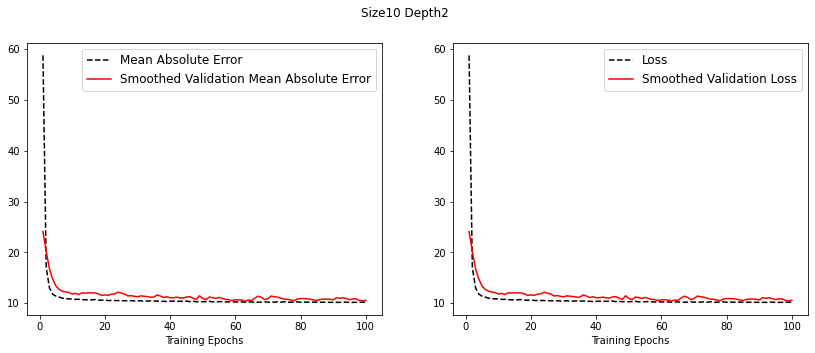

Negative Grad Identified


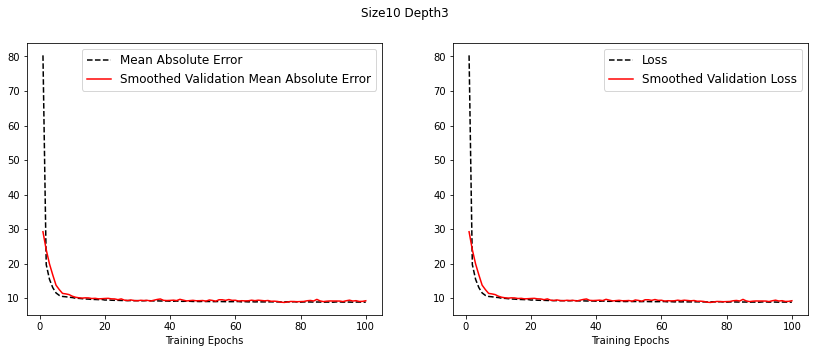

Negative Grad Identified
Negative Grad Identified


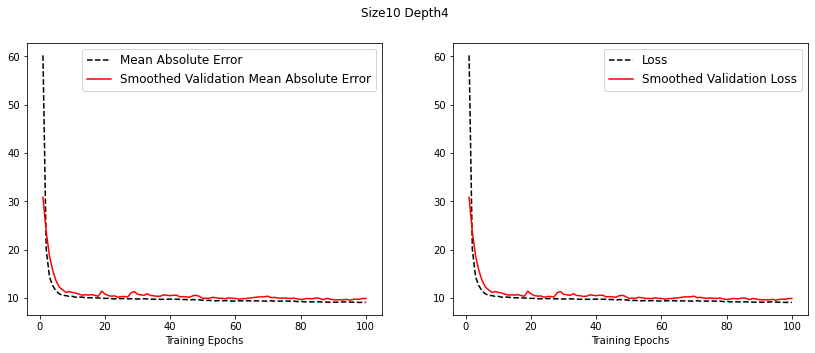

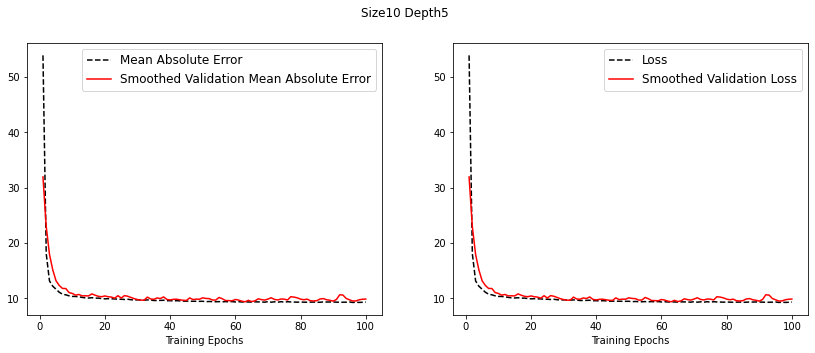

Negative Grad Identified
Negative Grad Identified


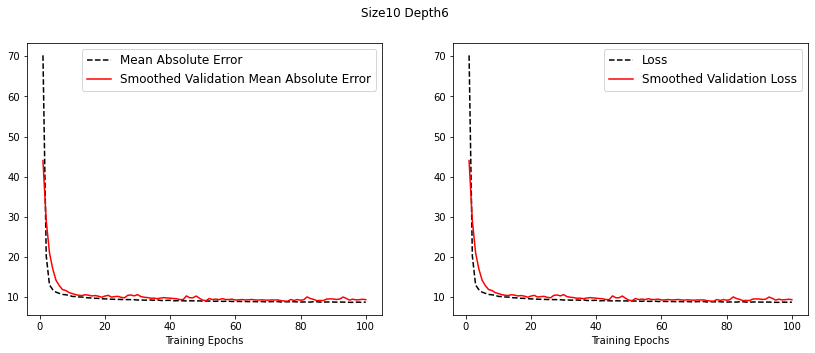

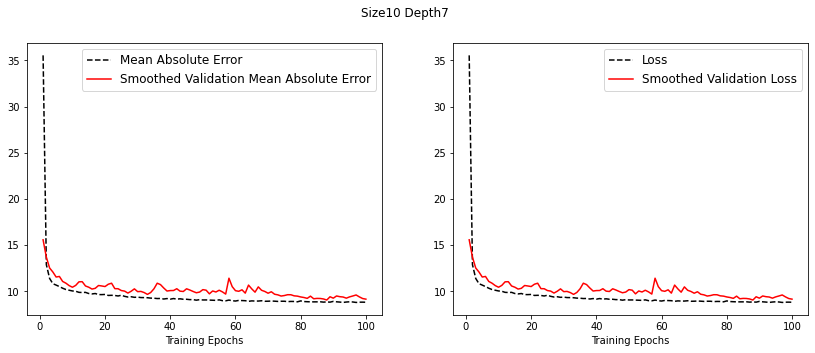

Negative Grad Identified


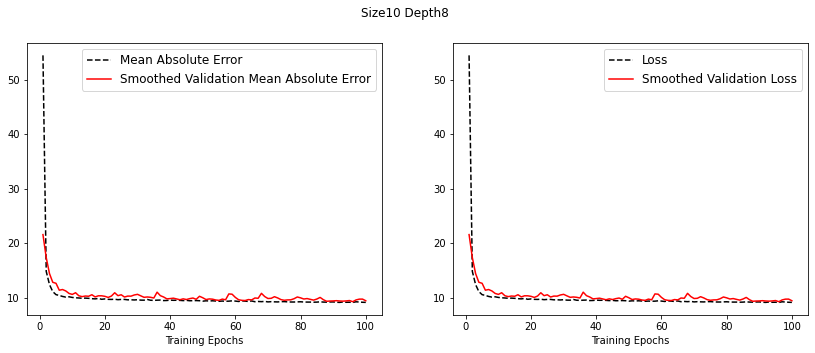

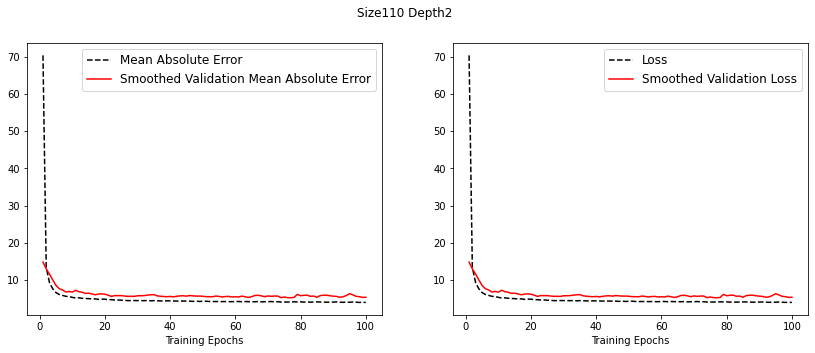

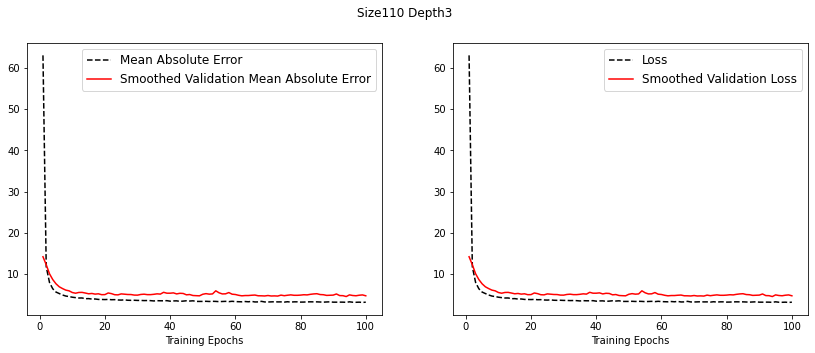

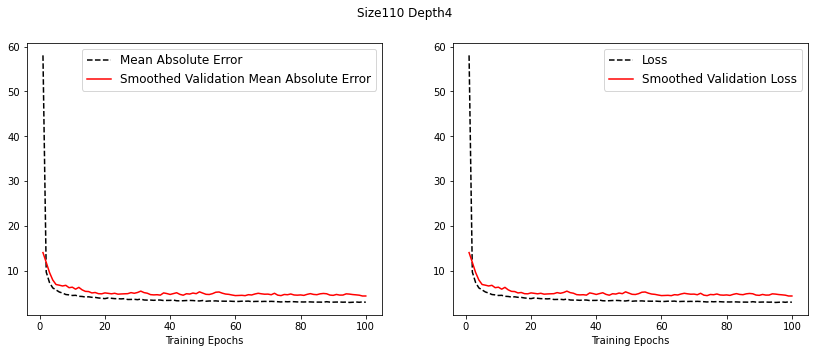

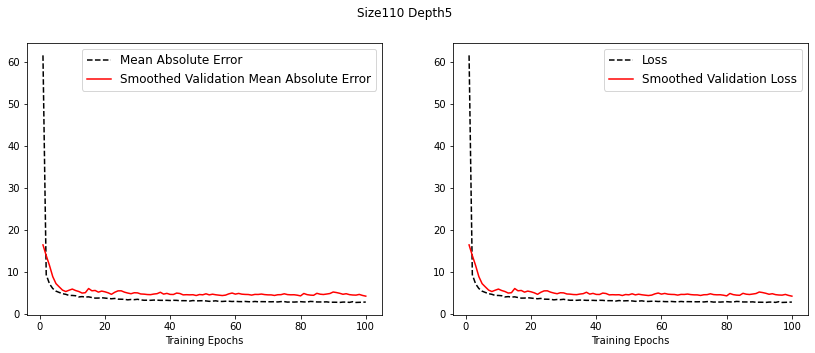

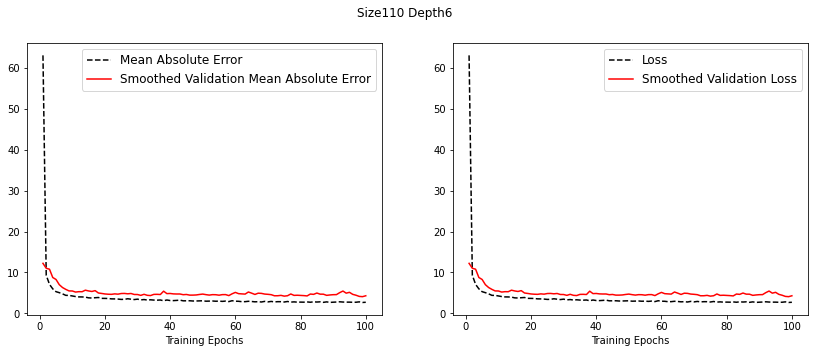

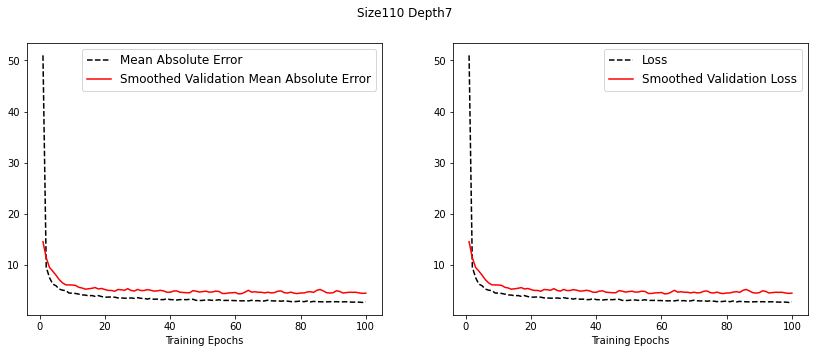

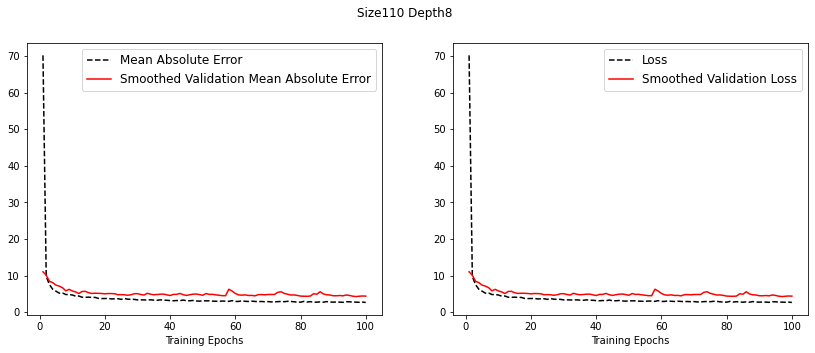

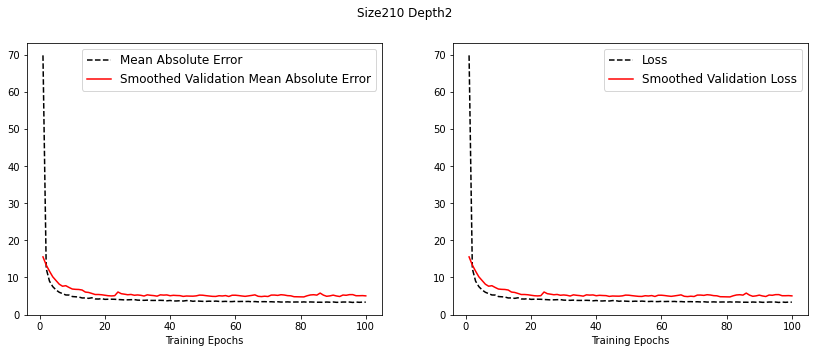

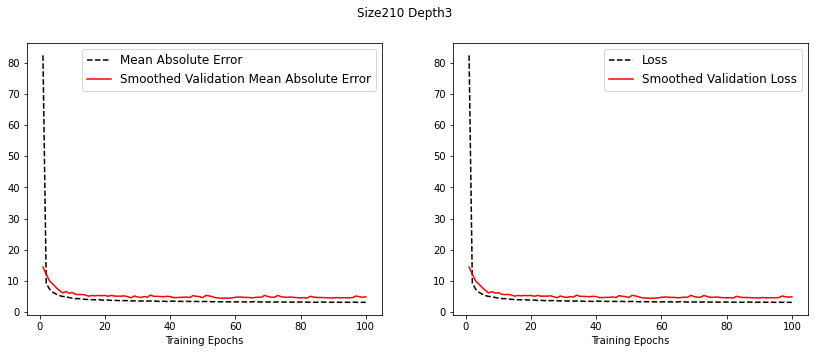

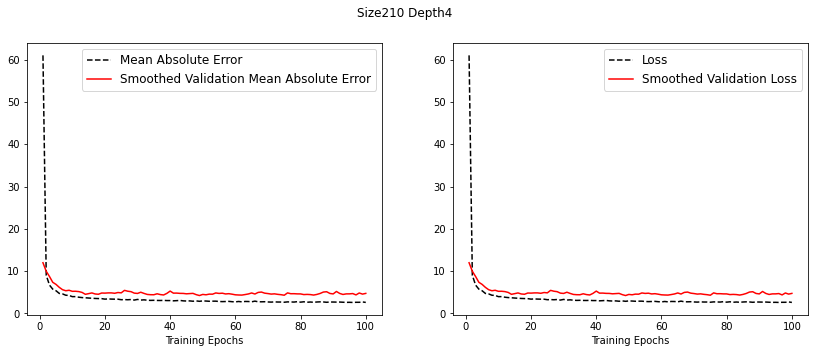

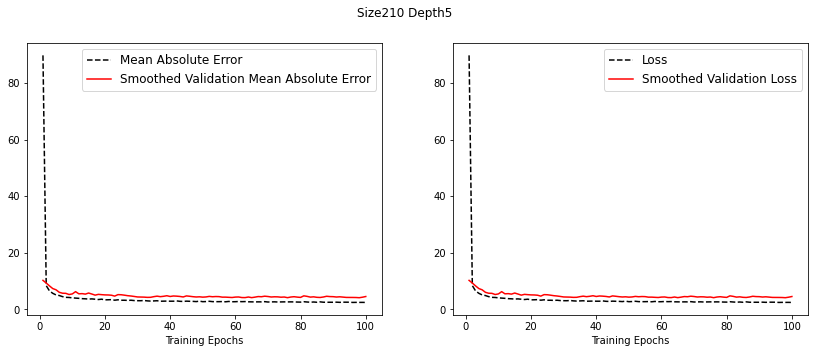

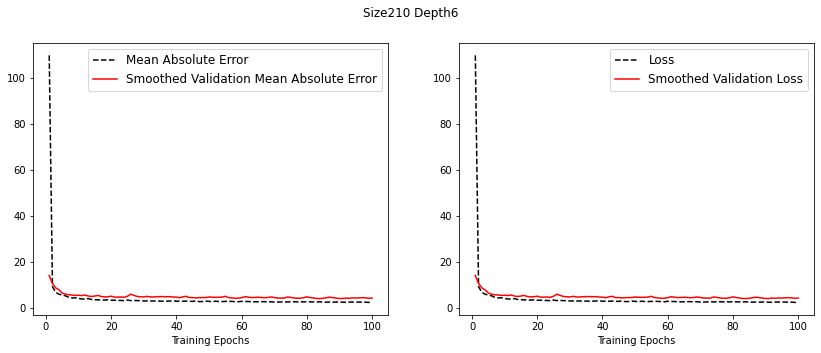

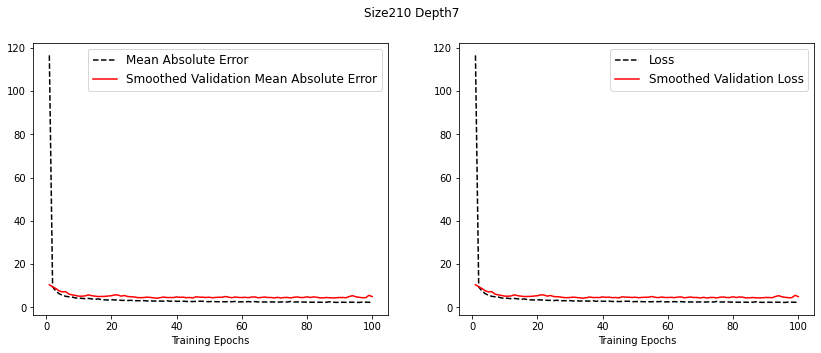

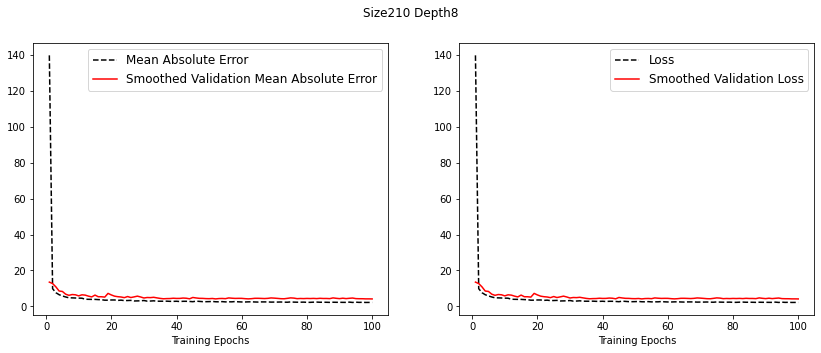

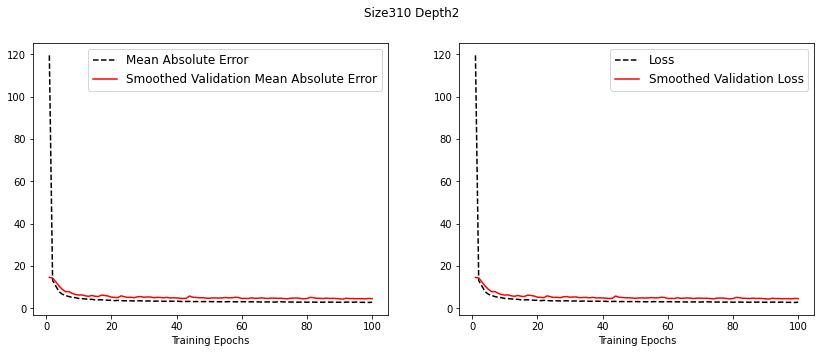

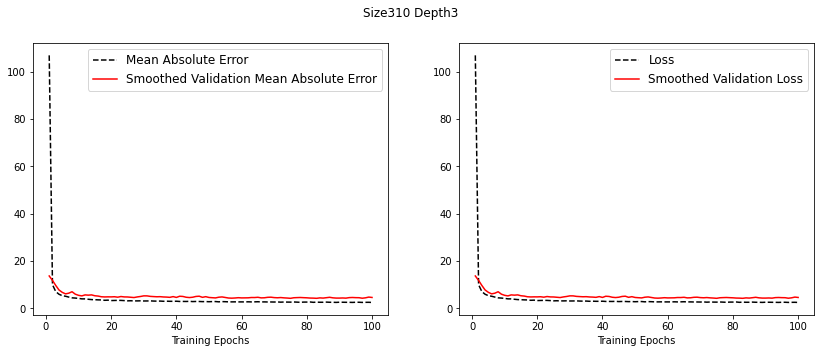

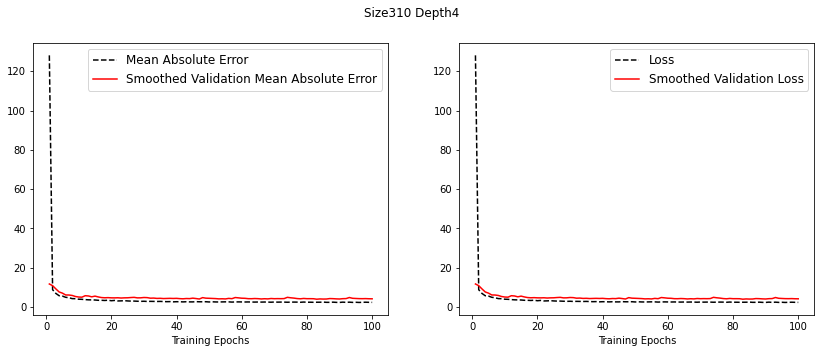

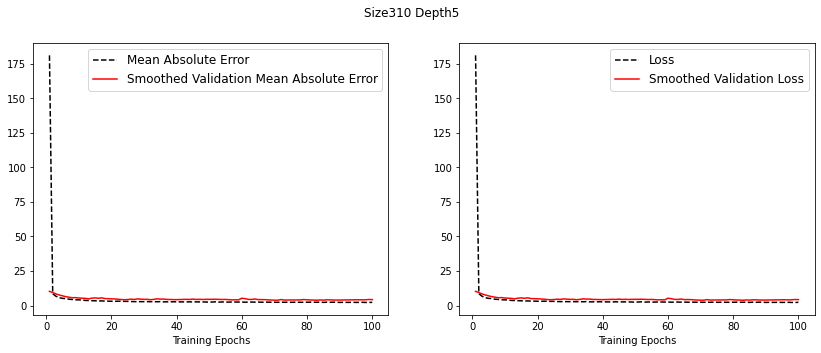

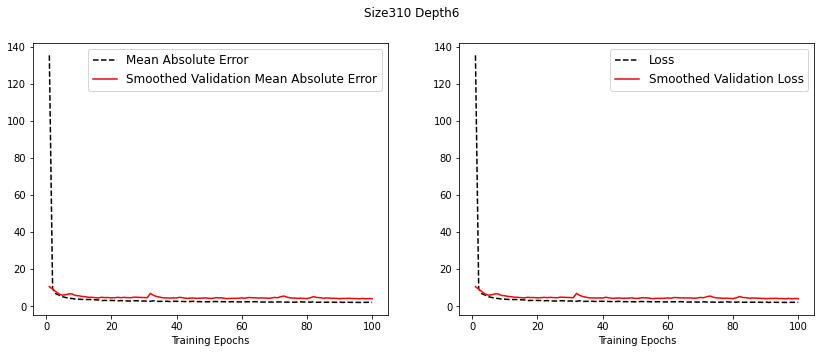

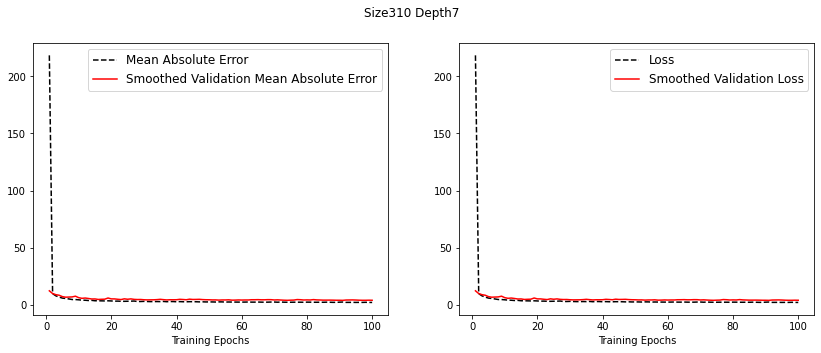

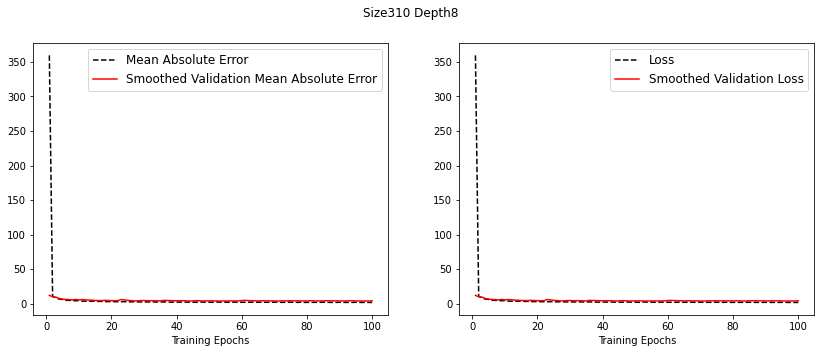

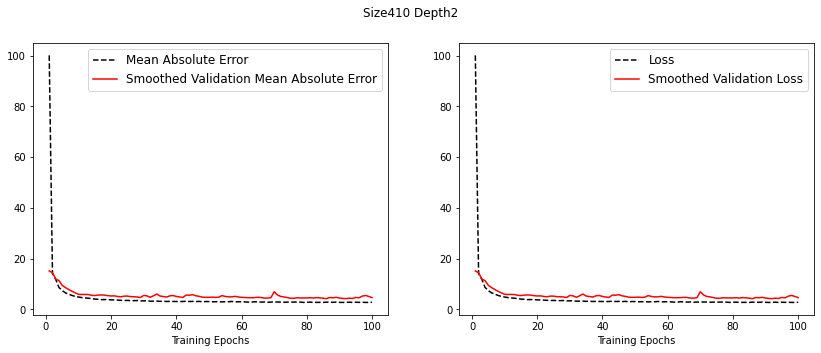

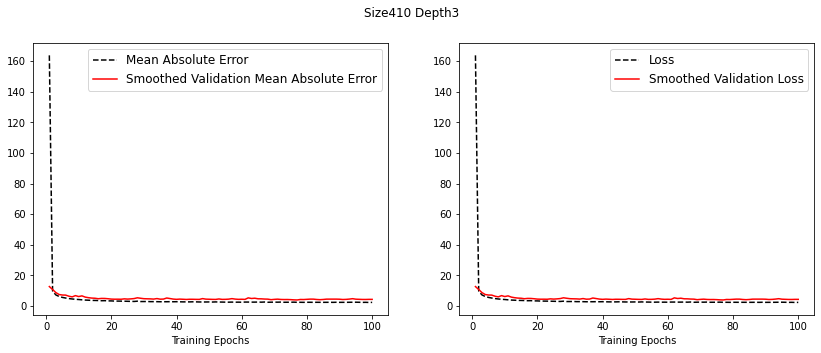

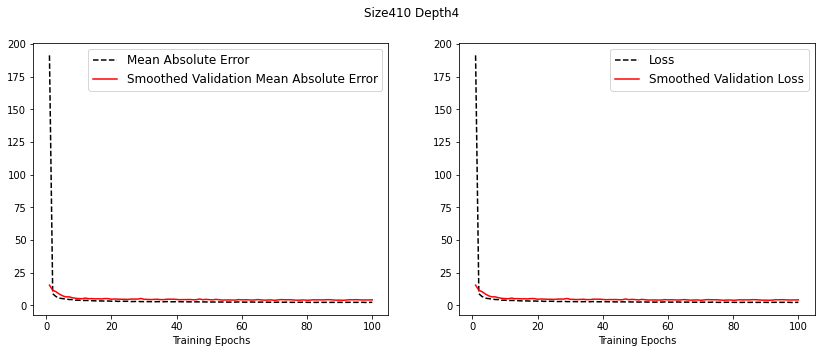

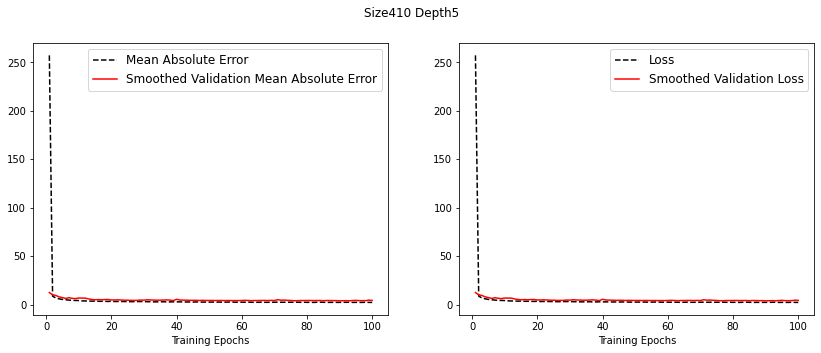

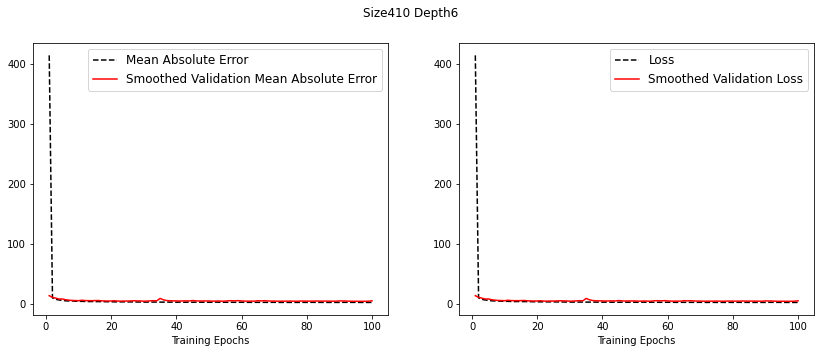

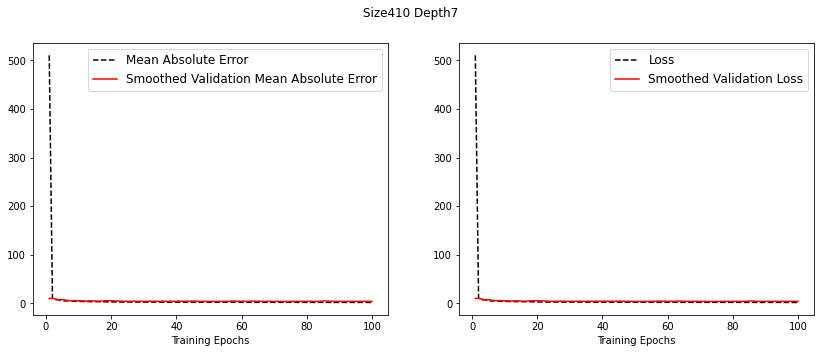

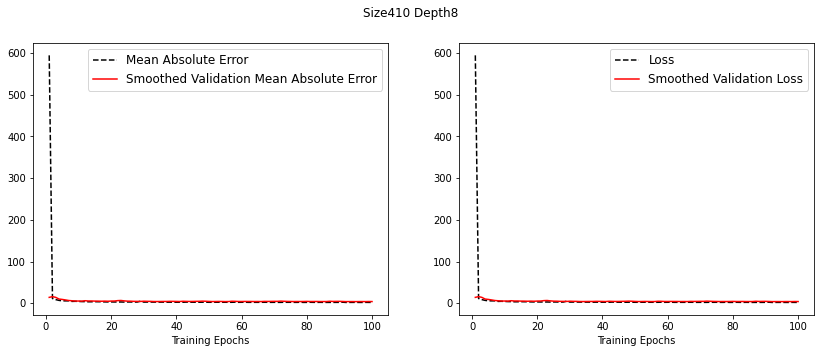

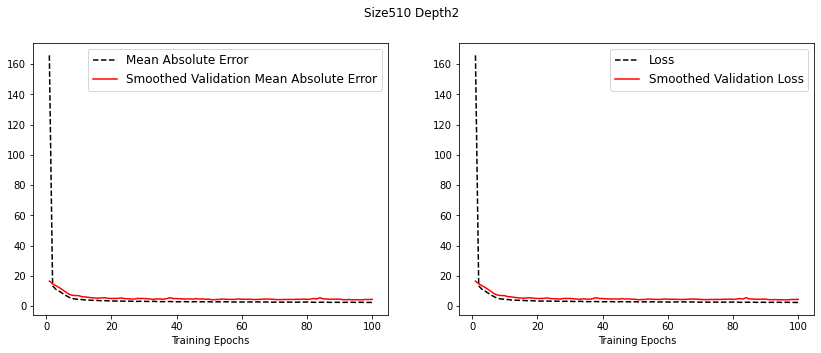

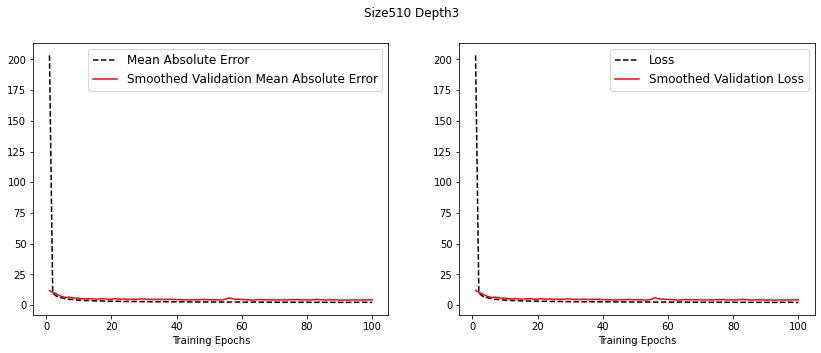

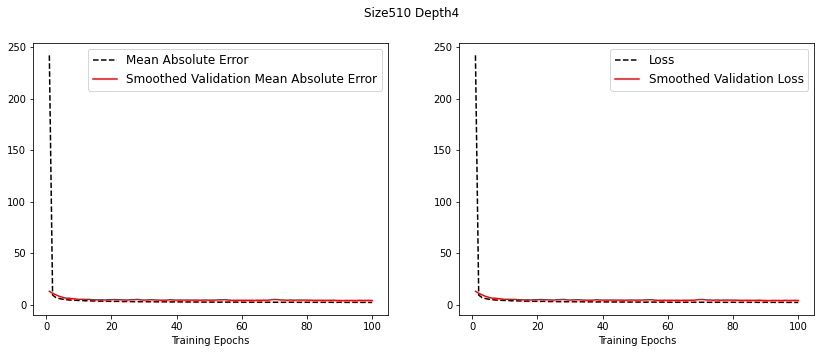

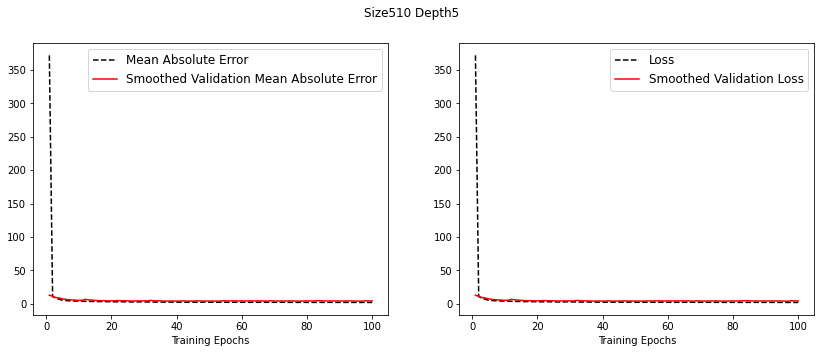

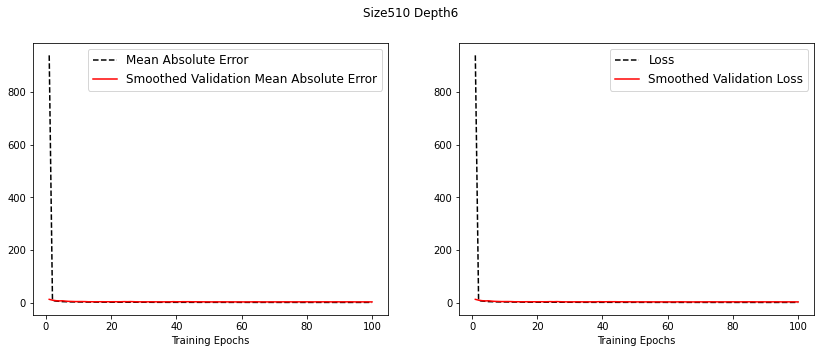

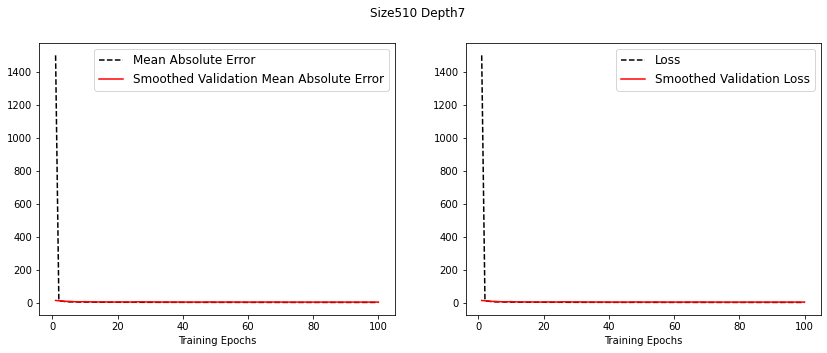

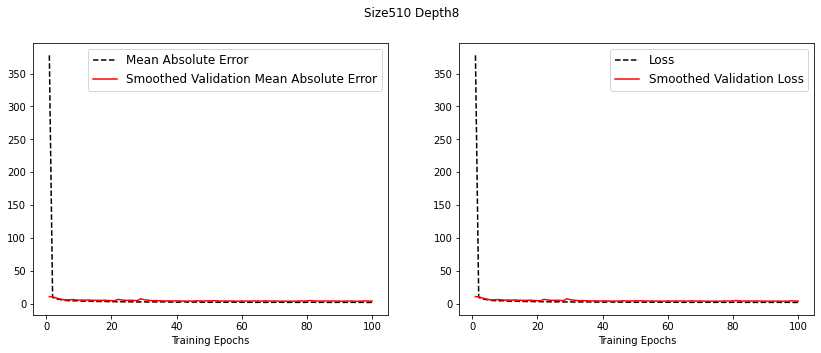

In [8]:
min_mape , layers, layer_sizes, histories, last_value = layers_tester((10,510),100,(2,8),8, epochs = 100)

In [18]:
min_mape_2d = min_mape.reshape(min_mape.shape[0],-1)
np.savetxt('Min_Mape_of_varying_layer_shapes.csv',min_mape_2d,delimiter=',')

In [89]:
min_mape_mean_load = np.loadtxt('Min_Mape_of_varying_layer_shapes.csv',delimiter=',')
#min_mape_mean_load = min_mape_mean_load.reshape(4,10,5)
min_mape_mean  = np.mean(min_mape,axis = 2)

min_index = np.where(np.min(min_mape_mean)==min_mape_mean)
min_mape_mean 

#print(min_mape_mean)


def return_not_convergerd(x,y,z,bools): 
    if bools.shape != z.shape:
        print('wrong size input')
    indecies = np.where(z*bools != 0)
 
    unconverged_z = []
    unconverged_x =[]
    unconverged_y = []
    for i in range(len(indecies)):
        print(indecies[i])
        unconverged_z.append(z[(indecies[i])[0],(indecies[i])[1]])
        unconverged_x.append(x[(indecies[i])[0]])
        unconverged_y.append(y[(indecies[i])[1]])
    return unconverged_x , unconverged_y , unconverged_z

x , y, z = return_not_convergerd(num_layers[0,:],layer_sizes,min_mape_mean,last_value )
print(x)

[0 0]
[2 4]
[2.0, 4.0]


In [78]:
num_layers = np.ones_like(min_mape_mean)*np.array(layers)
num_layers = num_layers
layer_sizes_array = ((np.ones_like(min_mape_mean)).transpose()*layer_sizes).transpose()
print(np.where(last_value != 0))

(array([0, 0]), array([2, 4]))


(2.0, 10.0)

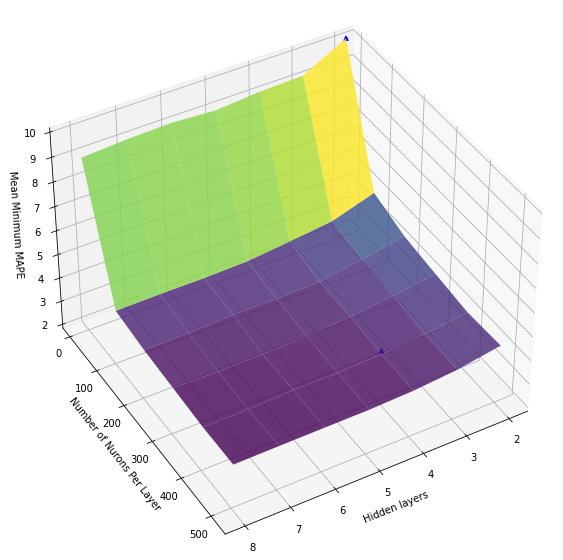

In [104]:

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.plot_surface(num_layers,layer_sizes_array,min_mape_mean,cmap = 'viridis', alpha = 0.8)
ax.scatter3D(x,y,z, color = 'blue',marker = '^', alpha = 1)
#ax.scatter3D(3,18,min_mape_mean[3,3])
ax.view_init(40,60)
ax.set_xlabel('Hidden layers')
ax.set_ylabel('Number of Nurons Per Layer')
ax.set_zlabel('Mean Minimum MAPE')
ax.set_zlim(2,10)
#ax.set_xticks((range(4,8)))
#ax.set_yticks(range(24,29))

In [105]:
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/Layers_Djuna_input.png',dpi = 300)

In [106]:
print('Optimised Layers =',num_layers[min_index],'Optimised Neuron_count= ', layer_sizes_array[min_index])
print('min_mae = ',np.min(min_mape_mean))

Optimised Layers = [7.] Optimised Neuron_count=  [410.]
min_mae =  3.849441394774271
